In [1]:
import os
import pandas as pd
import plotly.express as px
import numpy as np
import plotly.graph_objects as go
import plotly.io as pio

In [2]:
#setup = ["average", "pcr_dis", "lis_dis", "wg3_dis", 'all_dis','all_dis_meteo', "allpredictors"]

In [35]:
setup = ["PCR_uncalibrated", "wg3_dis", "pcr_dis", "lis_dis", "average", 
         "allpredictors", "all_dis", "all_dis_meteo", "allpredictors_cacht", "PCR_allpredictors"]

setup_dict = {index: value for index, value in enumerate(setup)}

print(setup_dict)

{0: 'PCR_uncalibrated', 1: 'wg3_dis', 2: 'pcr_dis', 3: 'lis_dis', 4: 'average', 5: 'allpredictors', 6: 'all_dis', 7: 'all_dis_meteo', 8: 'allpredictors_cacht', 9: 'PCR_allpredictors'}


In [16]:
import plotly.graph_objects as go

def combine_figures(combined_df, data_sampling, model, limit):
    fig = go.Figure()

    line_patterns = ['dash', 'dot', 'dashdot']
    #set_up_model = ['all_dis', 'all_dis_meteo', 'allpredictors']
    set_up_model = ["PCR_allpredictors", "allpredictors", "allpredictors_cacht", "all_dis", "all_dis_meteo"]
    
    # Calculate CDF for the 'KGE' column
    for i, (setup, group) in enumerate(combined_df.groupby('setup')):
        data_sorted = np.sort(group["KGE"])
        p = 1. * np.arange(len(group["KGE"])) / (len(group["KGE"]) - 1)

        # Determine line pattern based on setup name
        if setup in set_up_model:
            line_pattern = dict(dash='solid', width=5)
        else:
            line_pattern = dict(dash=line_patterns[i % len(line_patterns)], width=3)

        # Add trace for the CDF plot with custom line pattern
        fig.add_trace(go.Scatter(x=data_sorted, y=p, mode='lines', name=setup, line=line_pattern, legendgroup=setup))
    
    # Create the second figure
    # ... (code for the second figure)
    
    # Update layout for the combined figure
    fig.update_layout(
        title=f'Cumulative Distribution Function (CDF) {data_sampling} {model}',
        xaxis_title='KGE',
        yaxis_title='CDF',
        height=600,
        width=1000,
        showlegend=True
    )
    
    fig.update_xaxes(range=[limit, 1])
    return fig


In [17]:
def extract_kge(base_name, kge_variable, setup_id, data_sampling, model, rename=False):
    
    directory = f'../../R/{model}_output/validate/{data_sampling}/'    
    extract_path = os.path.join(directory, base_name)

    df_eval = pd.read_csv(extract_path)
    df_eval = df_eval[['grdc_no', kge_variable]] #'KGE_r', 'KGE_alpha', 'KGE_beta'
    df_eval = df_eval.assign(setup=setup[setup_id], subsample=subsample)
    
    if rename:
        df_eval = df_eval.rename(columns={kge_variable: 'KGE'})
    return df_eval


## All stations & rhine only

In [18]:
validation_setup = "rhine_only"
model = "MLR"

In [87]:
subsample_KGE_list = {}
for subsample in range(1, 6):
    
    allpredictors = 'subsample_' + str(subsample) + '/KGE_allpredictors.csv'    
    all_dis = 'subsample_' + str(subsample) + '/KGE_all_dis.csv'
    all_dis_meteo = 'subsample_' + str(subsample) + '/KGE_all_dis_meteo.csv'

    df_wg3 = extract_kge(allpredictors, "KGE_wg3", 1, validation_setup, model, rename=True)
    df_pcr = extract_kge(allpredictors, "KGE_pcr", 2, validation_setup, model, rename=True)
    df_lis = extract_kge(allpredictors, "KGE_lis", 3, validation_setup, model, rename=True)
    df_mean = extract_kge(allpredictors, "KGE",  4, validation_setup,  model)


    df_allpredictors = extract_kge(allpredictors, "KGE_corrected",  5, validation_setup, model, rename=True)
    df_eval_all_dis = extract_kge(all_dis, "KGE_corrected",  6,  validation_setup, model, rename=True)
    df_eval_all_dis_meteo = extract_kge(all_dis_meteo, "KGE_corrected", 7,  validation_setup, model, rename=True)

    
    #df_pcr_allpredictors = extract_kge(allpredictors, "KGE_corrected",  8,  "rhine_pcr", "RF", rename=True)



    subsample_KGE = pd.concat([df_wg3, df_pcr, df_lis, df_mean, df_allpredictors, df_eval_all_dis, df_eval_all_dis_meteo]).reset_index(drop=True)

    subsample_KGE_list[subsample] = subsample_KGE
combined_df = pd.concat(subsample_KGE_list.values()).reset_index(drop=True)

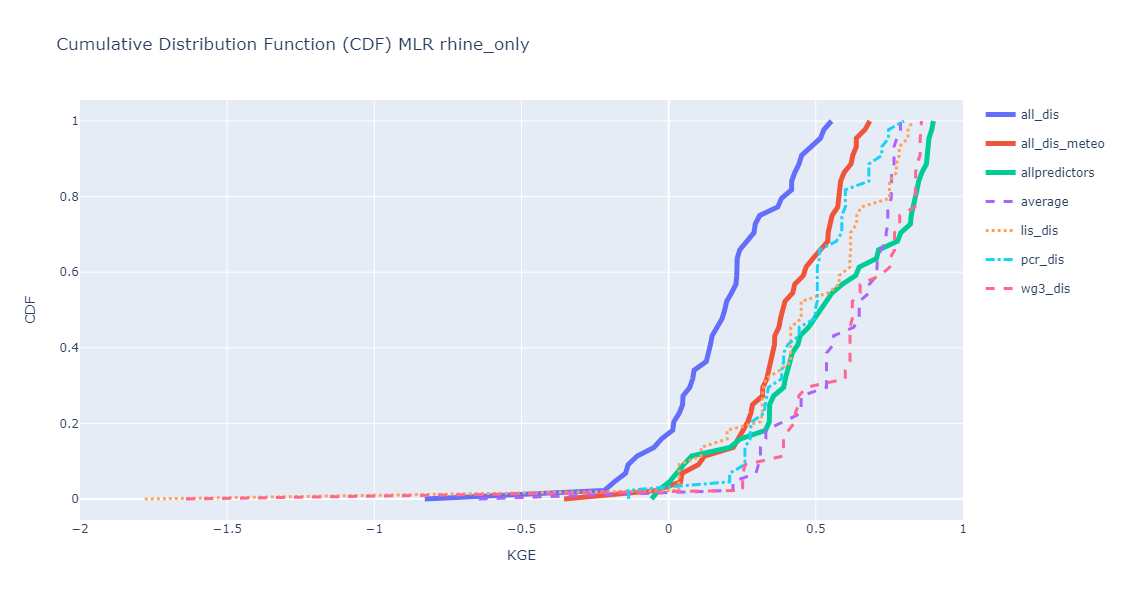

In [89]:
filename = f'../../R/figures_rapport/{validation_setup}_{model}.png'

fig1 = combine_figures(combined_df, model, validation_setup, -2)
fig1.show()

In [90]:
pio.write_image(fig1, filename, format='png')

## Single sample

In [57]:
model = "RF"
validation_setup = "elbe"
subsample = 5

In [58]:
allpredictors = 'KGE_allpredictors.csv'    
all_dis = 'KGE_all_dis.csv'
all_dis_meteo = 'KGE_all_dis_meteo.csv'

#standard variables, these ramain the same and are not dependent on model
df_eval_wg3 = extract_kge(allpredictors, "KGE_wg3",  1, validation_setup, model, rename=True)
df_eval_pcr = extract_kge(allpredictors, "KGE_pcr", 2, validation_setup, model, rename=True)
df_eval_lis = extract_kge(allpredictors, "KGE_lis", 3, validation_setup, model, rename=True)
df_mean = extract_kge(allpredictors, "KGE",  4, validation_setup,  model)



#Discharge corrected 
df_allpredictors = extract_kge(allpredictors, "KGE_corrected",  5, validation_setup, model, rename=True)
df_eval_all_dis = extract_kge(all_dis, "KGE_corrected",  6, validation_setup, model, rename=True)
df_eval_all_dis_meteo =extract_kge(all_dis_meteo, "KGE_corrected",  7, validation_setup, model, rename=True)


df_allpredictors_catch = extract_kge(allpredictors, "KGE_corrected",  8, "elbe_catchAtt", "RF", rename=True)

#subsample_KGE = pd.concat([df_mean, df_eval_lis, df_eval_pcr, df_eval_wg3, df_allpredictors, df_eval_all_dis, df_eval_all_dis_meteo]).reset_index(drop=True)
subsample_KGE = pd.concat([df_eval_lis, df_eval_pcr, df_eval_wg3, df_allpredictors, df_allpredictors_catch]).reset_index(drop=True)

In [59]:
#percentage_below_threshold = round(100 - (df_allpredictors_catch["KGE"] < -0.41).mean() * 100)
#percentage_below_threshold

In [60]:
title = "allpredictors vs allpredictors_cacth"

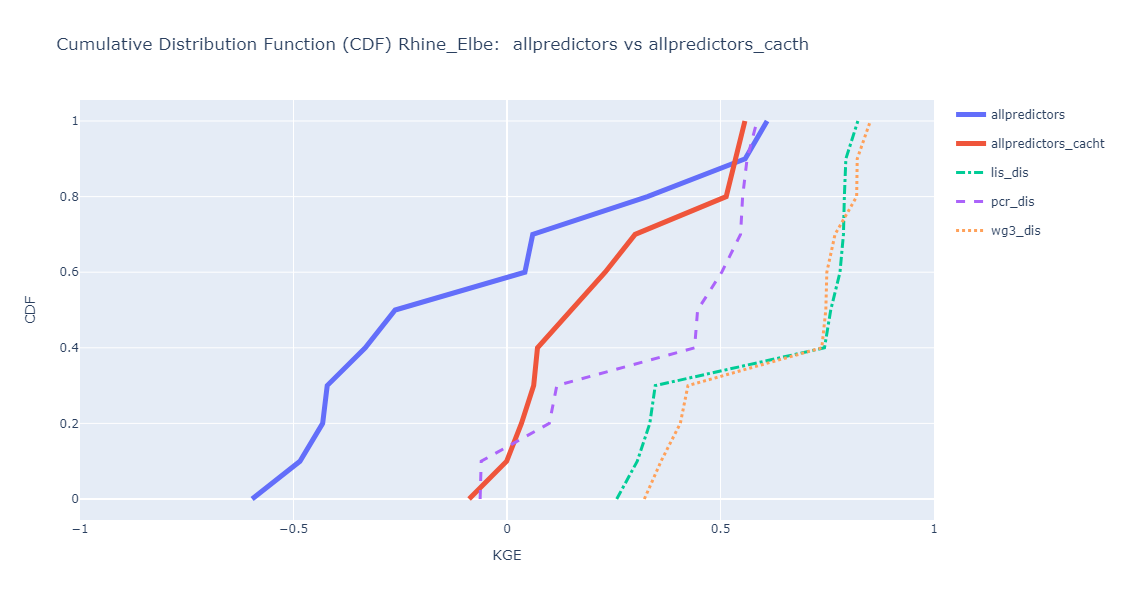

In [62]:
fig_elbe = combine_figures(subsample_KGE, "Rhine_Elbe: ", title, -1)
fig_elbe.show()

In [65]:
validation_setup = "elbe_catch"
filename = f'../../R/figures_rapport/{validation_setup}_{model}.png'
filename

'../../R/figures_rapport/elbe_catch_RF.png'

In [66]:
pio.write_image(fig_elbe, filename, format='png')

model = "RF"
data_sampling = "Maas"

filename_maas = f'../../R/figures_rapport/{data_sampling}_{model}.png'
fig_maas = combine_figures(subsample_KGE, model, data_sampling, -5)
fig_maas.show()
pio.write_image(fig_maas, filename_maas, format='png')